In [1]:
import sqlite3
import pandas as pd
from contextlib import closing

In [4]:
'''
with closing(sqlite3.connect("../db/remote-simulations.db")) as connection:
    with closing(connection.cursor()) as cursor:
        rows = cursor.execute("SELECT * from results").fetchall()
        print(rows)
'''
with closing(sqlite3.connect("../db/remote-simulations.db")) as connection:
    sql_query = pd.read_sql_query("SELECT * from results", connection)
    results = pd.DataFrame(sql_query)

results.head()    

,execution_time,experiment_id,window_size,max_nodes,nodes_count,max_services,services_count,dataset,metric_name,metric_value,percentage,lower_bound,upper_bound
0,0.373318,1,1,5,2,5,2,high_variability_10k,qualitative,0.471478,0.246347,0.2,1.0
1,0.152372,1,2,5,2,5,2,high_variability_10k,qualitative,0.471478,0.246347,0.2,1.0
2,0.276697,1,1,5,3,5,2,high_variability_10k,qualitative,0.579754,0.134242,0.2,1.0
3,0.313675,1,2,5,3,5,2,high_variability_10k,qualitative,0.685679,0.058040,0.2,1.0
4,0.270103,1,3,5,3,5,2,high_variability_10k,qualitative,0.685679,0.058040,0.2,1.0


In [9]:
import operator
import functools

tested_datasets = results['dataset'].unique()
NODES_COUNT = 5
SERVICES_COUNT = 5
METRIC_NAME = 'qualitative'
LOWER_BOUND = 0.2
UPPER_BOUND = 1.0

results_filters = [
    lambda df: df['services_count'] == SERVICES_COUNT,
    lambda df: df['nodes_count'] == NODES_COUNT,
    lambda df: df['metric_name'] == METRIC_NAME,
    lambda df: df['lower_bound'] == LOWER_BOUND,
    lambda df: df['upper_bound'] == UPPER_BOUND
]

def apply_filters_to_dataset(df, filters):
    compound_condition = functools.reduce(operator.and_, map(lambda filter: filter(df), filters))
    return df[compound_condition]

exhaustive_metric_value = {
    dataset: apply_filters_to_dataset(results,
                                      results_filters + [
                                          lambda df: df['dataset'] == dataset, 
                                          lambda df: df['window_size'] == NODES_COUNT
                                      ]
                                     ).metric_value.iloc[0] \
        for dataset in tested_datasets
}

results_per_dataset = {}
for dataset in tested_datasets:
    dataset_results = apply_filters_to_dataset(results, results_filters + [lambda df: df['dataset'] == dataset]) \
        .sort_values(by=['experiment_id', 'window_size'])

    display(dataset_results)
    results_per_dataset[dataset] = dataset_results

exhaustive_metric_value

,execution_time,experiment_id,window_size,max_nodes,nodes_count,max_services,services_count,dataset,metric_name,metric_value,percentage,lower_bound,upper_bound
51,0.842213,1,1,5,5,5,5,high_variability_10k,qualitative,0.809546,0.005075,0.2,1.0
52,3.000657,1,2,5,5,5,5,high_variability_10k,qualitative,0.818234,0.002822,0.2,1.0
53,11.132194,1,3,5,5,5,5,high_variability_10k,qualitative,0.822968,0.001843,0.2,1.0
54,37.231943,1,4,5,5,5,5,high_variability_10k,qualitative,0.822968,0.001843,0.2,1.0
55,96.892254,1,5,5,5,5,5,high_variability_10k,qualitative,0.822968,0.001843,0.2,1.0


,execution_time,experiment_id,window_size,max_nodes,nodes_count,max_services,services_count,dataset,metric_name,metric_value,percentage,lower_bound,upper_bound
107,0.315678,1,1,5,5,5,5,low_variability_10k,qualitative,0.065486,0.007352,0.2,1.0
108,1.148966,1,2,5,5,5,5,low_variability_10k,qualitative,0.073709,0.006033,0.2,1.0
109,4.373197,1,3,5,5,5,5,low_variability_10k,qualitative,0.123953,0.003671,0.2,1.0
110,15.549916,1,4,5,5,5,5,low_variability_10k,qualitative,0.082504,0.003056,0.2,1.0
111,41.600150,1,5,5,5,5,5,low_variability_10k,qualitative,0.123953,0.003671,0.2,1.0


,execution_time,experiment_id,window_size,max_nodes,nodes_count,max_services,services_count,dataset,metric_name,metric_value,percentage,lower_bound,upper_bound
163,1.181839,1,1,5,5,5,5,inmates_enriched_10k,qualitative,0.651297,0.015161,0.2,1.0
164,4.150197,1,2,5,5,5,5,inmates_enriched_10k,qualitative,0.757102,0.002909,0.2,1.0
165,15.855065,1,3,5,5,5,5,inmates_enriched_10k,qualitative,0.757102,0.002909,0.2,1.0
166,53.826117,1,4,5,5,5,5,inmates_enriched_10k,qualitative,0.751385,0.003934,0.2,1.0
167,135.954415,1,5,5,5,5,5,inmates_enriched_10k,qualitative,0.757102,0.002909,0.2,1.0


{'high_variability_10k': np.float64(0.8229680018692729),
 'low_variability_10k': np.float64(0.12395343491776281),
 'inmates_enriched_10k': np.float64(0.7571024859308717)}

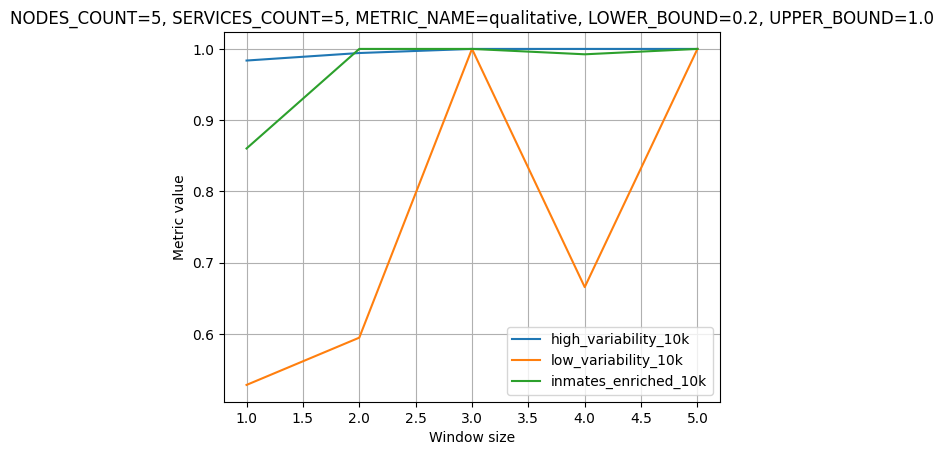

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# plt.figure(figsize=(10, 6))

for dataset, dresults in results_per_dataset.items():
    ax.plot(dresults['window_size'], dresults['metric_value'] / exhaustive_metric_value[dataset], label=dataset)

ax.set_title(f'NODES_COUNT={NODES_COUNT}, SERVICES_COUNT={SERVICES_COUNT}, METRIC_NAME={METRIC_NAME}, LOWER_BOUND={LOWER_BOUND}, UPPER_BOUND={UPPER_BOUND}')
ax.set_xlabel('Window size')
ax.set_ylabel('Metric value')
ax.grid(True)
ax.legend()

plt.show()
    